In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# 1. Prepare Dadaset

In [4]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [5]:
train_path = './data/DailyDelhiClimateTrain.csv'
test_path = './data/DailyDelhiClimateTest.csv'

In [6]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [7]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

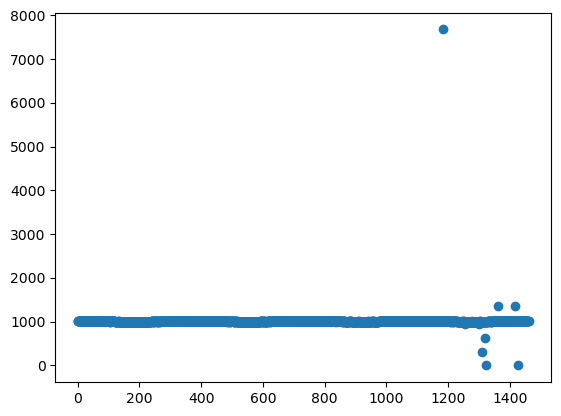

In [8]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [9]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


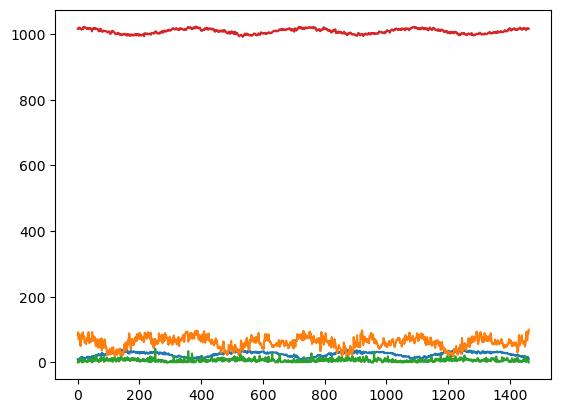

In [10]:
plt.plot(train)

In [11]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [12]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

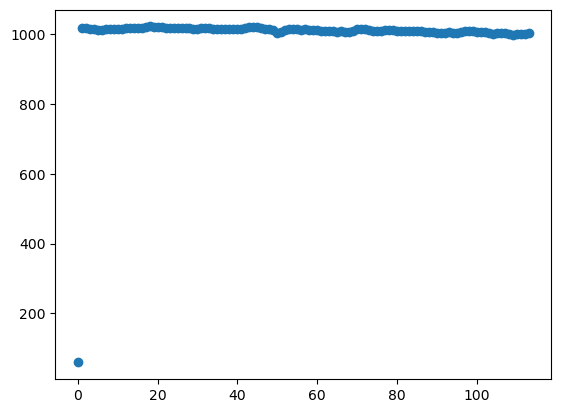

In [13]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [14]:
test.iloc[0][3] = test.iloc[1][3]

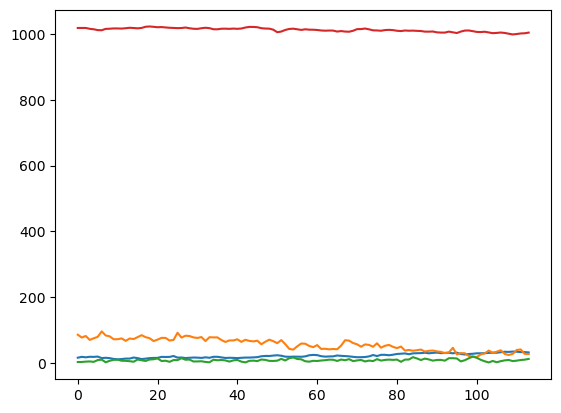

In [15]:
plt.plot(test)

## 1.2 Transfer data to LSTM representation

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [18]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [19]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [20]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

### - data loader

In [21]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

In [22]:
print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of test_data: 440


In [23]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [24]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# LSTM

In [25]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [26]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        out, _ = self.rnn(x, h0)
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [27]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and abs(loss - train_loss) < 1e-4:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

## 3.2 Evaluate Model

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=train_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [34]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [35]:
model = Model(input_size, hidden_size, num_output, 
                num_layers = num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0008)
loss_func = nn.MSELoss()

start = time.time()
losses = train_model(model, train_data, batch_size=20,          
               loss_func = loss_func, optimizer = optimizer, epoch = 50, early_stop=True)
end = time.time()

print(f'time costs: {end - start}')

Epoch 1/50: Loss: 1.0846144646406173
Epoch 2/50: Loss: 0.7722144693136215
Epoch 3/50: Loss: 0.5367884337902069
Epoch 4/50: Loss: 0.3667537845671177
Epoch 5/50: Loss: 0.25001602433621883
Epoch 6/50: Loss: 0.112610056810081
Epoch 7/50: Loss: 0.04512231386033818
Epoch 8/50: Loss: 0.023235841724090277
Epoch 9/50: Loss: 0.004230201106111053
Epoch 10/50: Loss: 0.0006387600922607816
Epoch 11/50: Loss: 0.00048541555693191183
Epoch 12/50: Loss: 0.0003223484845875646
Epoch 13/50: Loss: 0.00028296616073930636
Epoch 14/50: Loss: 0.0002753048821432458
Epoch 15/50: Loss: 0.00024400993734161603
Epoch 16/50: Loss: 0.00023244755548148532
Epoch 17/50: Loss: 0.00037887690268689767
Epoch 18/50: Loss: 0.0002606883947009919
Epoch 19/50: Loss: 0.0002563020969319041
Epoch 20/50: Loss: 0.00022482446238427655
Epoch 21/50: Loss: 0.00026348773294557757
Epoch 22/50: Loss: 0.00020941580569342478
Epoch 23/50: Loss: 0.000308434819089598
Epoch 24/50: Loss: 0.00022854588578411495
Epoch 25/50: Loss: 0.000327529328933451

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [ ]:
calculate_accuarcy(model, X_test, y_test)

### - describe trained model

In [220]:
model

Model(
  (rnn): RNN(12, 32, num_layers=2)
  (predict): Linear(in_features=32, out_features=4, bias=True)
)

In [221]:
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_parameters

3716

### - save the model

In [193]:
# save the model
# torch.save(model.state_dict(), "model/model_classical.pt")

# 4. Plot Results

In [240]:
results = []

for i in range(0, len(X_test), features_size):
    input_data = X_test[i:i+1]
    result = model(input_data)
    result = test_scaler.inverse_transform(result.data)
    
    results.append(result[0])

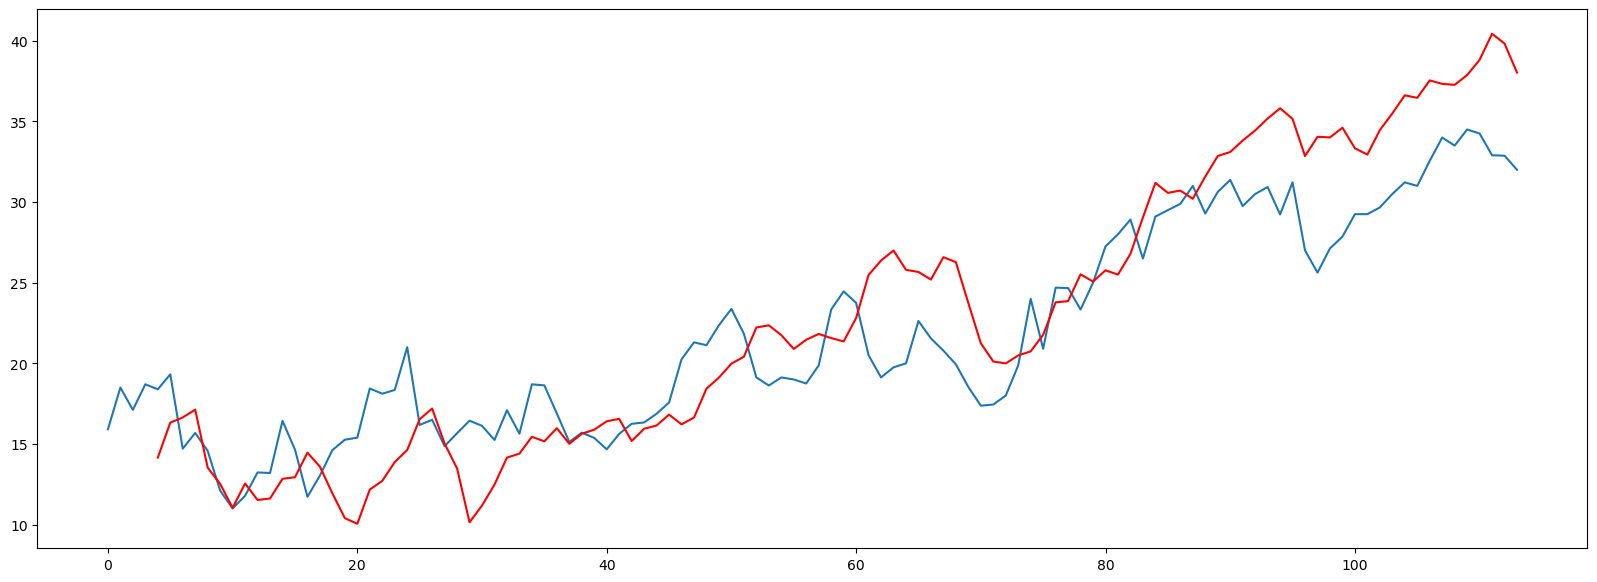

In [241]:
plt.figure(figsize=(20, 7))
plt.plot(test['meantemp'])
meantemp = [ r[0] for r in results ] 
meantemp = [None, None, None, None] + meantemp
plt.plot(meantemp, color="red")
plt.show()

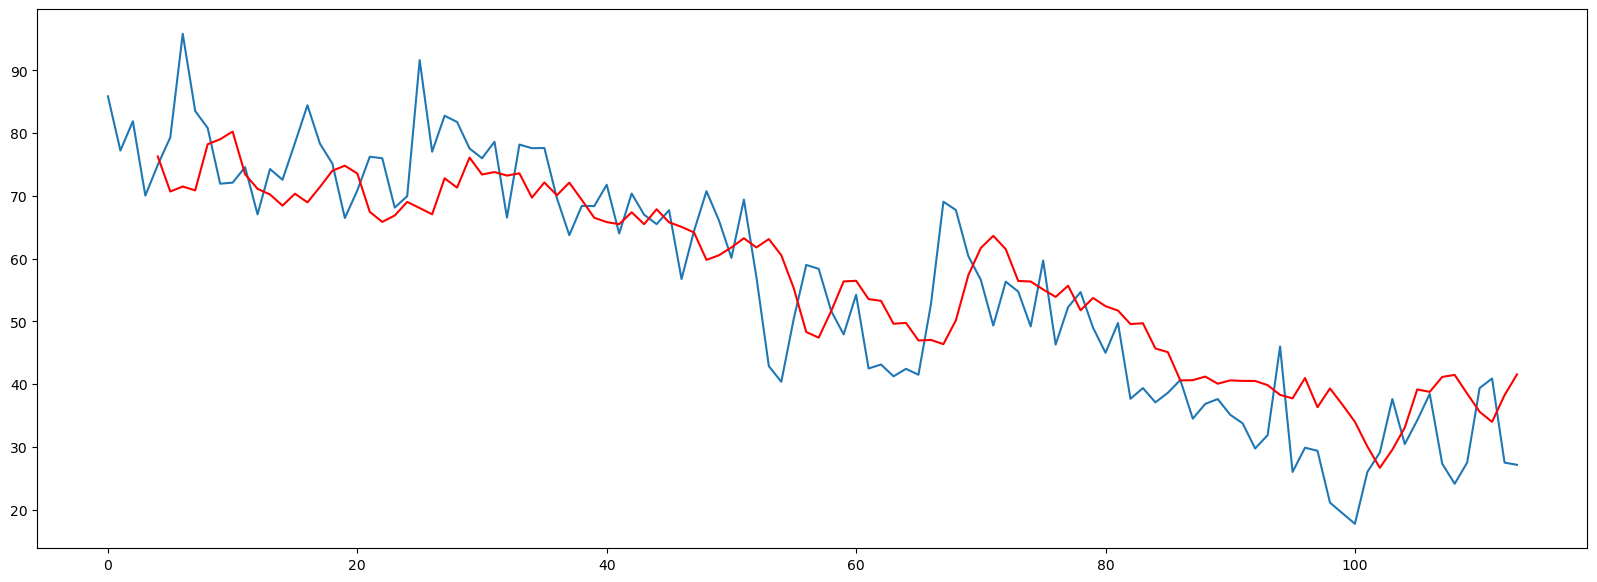

In [242]:
plt.figure(figsize=(20, 7))
plt.plot(test['humidity'])
humidity = [ r[1] for r in results ] 
humidity = [None, None, None, None] + humidity
plt.plot(humidity, color="red")
plt.show()

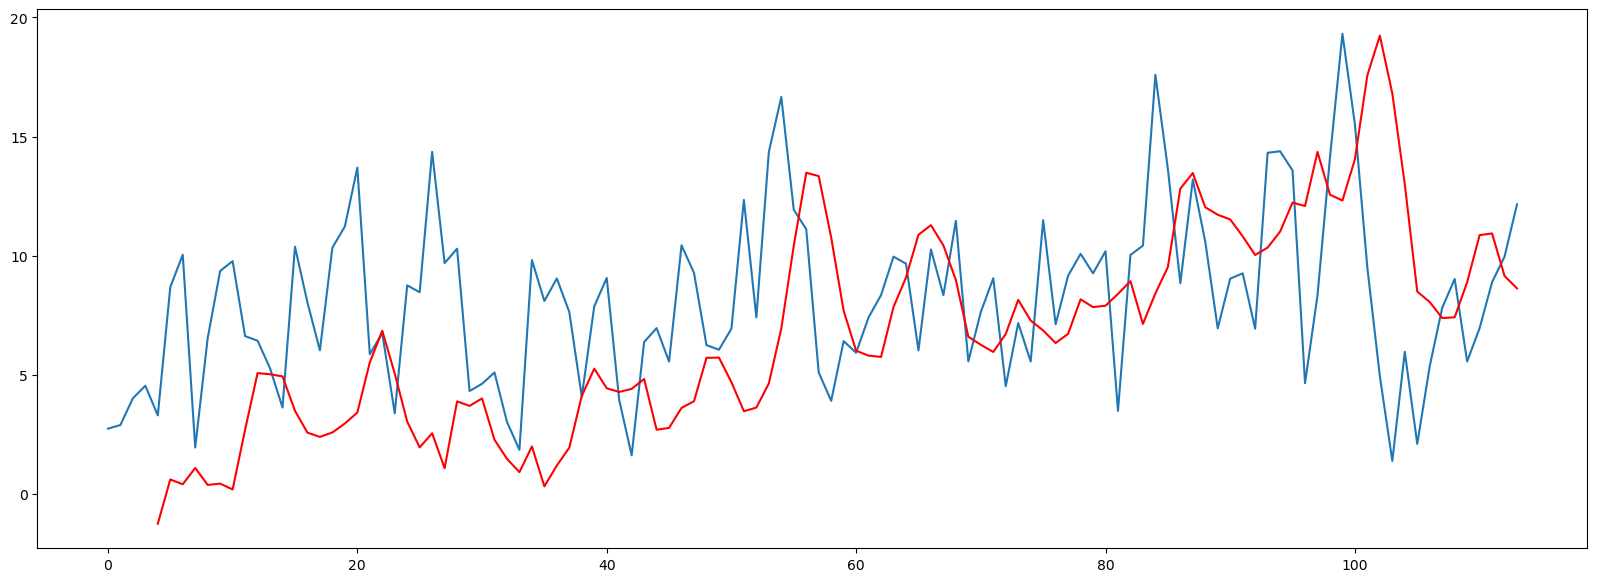

In [243]:
plt.figure(figsize=(20, 7))
plt.plot(test['wind_speed'])
wind_speed = [ r[2] for r in results ] 
wind_speed = [None, None, None, None] + wind_speed
plt.plot(wind_speed, color="red")
plt.show()

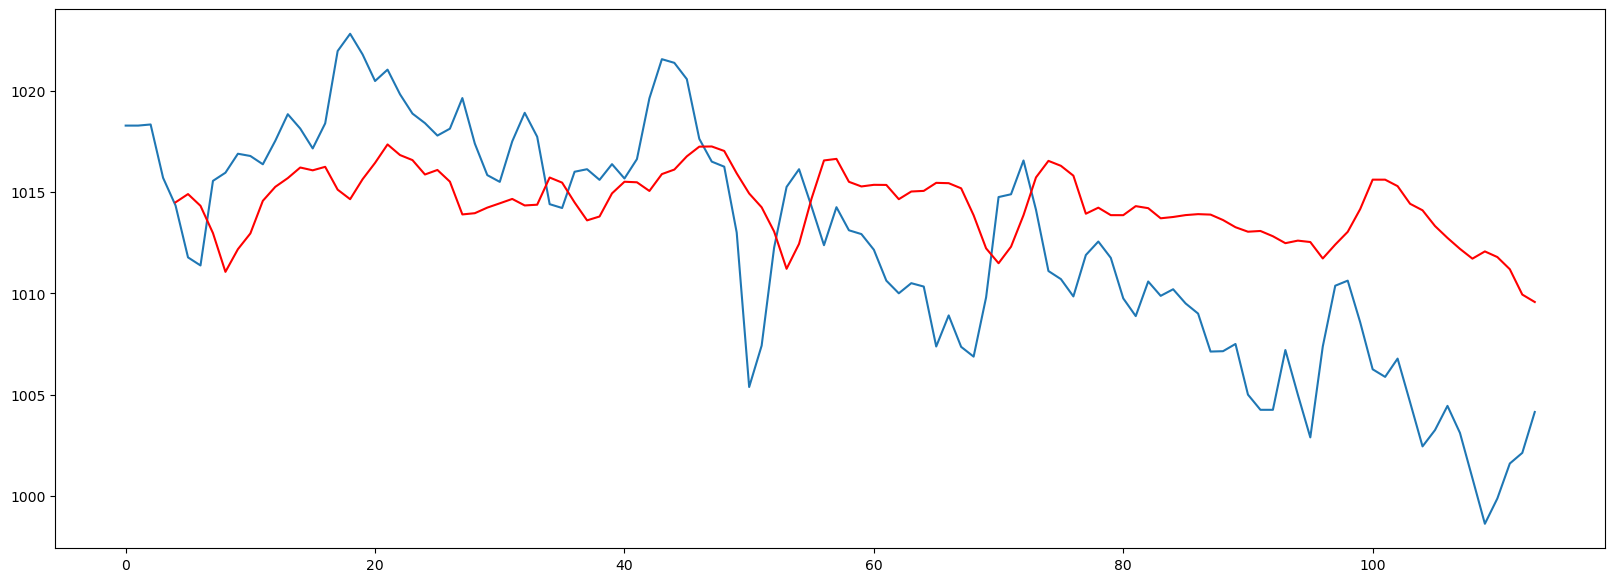

In [198]:
plt.figure(figsize=(20, 7))
plt.plot(test['meanpressure'])
meanpressure = [ r[3] for r in results ] 
meanpressure = [None, None, None, None] + meanpressure
plt.plot(meanpressure, color="red")
plt.show()

## - test and results

In [199]:
test1 = pd.DataFrame(test, columns=('meantemp', 'humidity', 'wind_speed'))
test2 = pd.DataFrame(test, columns=('meanpressure',))

In [200]:
results = pd.DataFrame(results)
results.columns = ('meantemp', 'humidity', 'wind_speed', 'meanpressure')
results

,meantemp,humidity,wind_speed,meanpressure
0,23.365720,58.815976,9.023422,1014.491447
1,23.976979,55.702667,11.138920,1014.897546
2,24.312615,55.125140,11.279921,1014.317681
3,25.488768,54.752060,12.650481,1012.971422
4,24.051991,60.451684,11.113933,1011.059126
...,...,...,...,...
105,38.819478,28.837256,22.180976,1012.067460
106,39.482643,25.706917,23.968844,1011.789169
107,40.194283,23.837350,25.842097,1011.188205
108,40.698323,26.648601,24.581832,1009.937523


In [152]:
result1 = pd.DataFrame(results, columns=('meantemp', 'humidity', 'wind_speed'))
result2 = pd.DataFrame(results, columns=('meanpressure',))

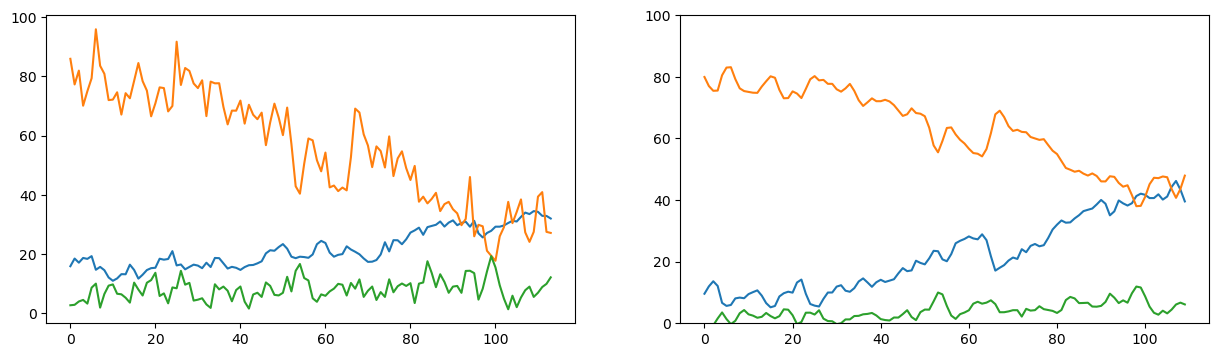

In [153]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(test1)
plt.subplot(1,2,2)
plt.ylim(0, 100)
plt.plot(result1)

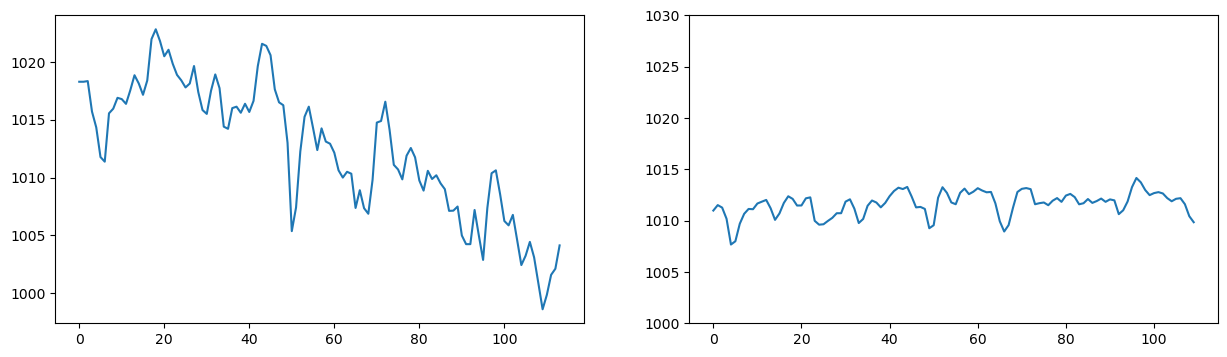

In [154]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(test2)
plt.subplot(1,2,2)
plt.ylim(1000, 1030)
plt.plot(result2)